# Hands on: Reinforcement Learning

In this tutorial we implement the REINFORCE algorithm as described in *Reinforcement Learning: An Introduction by Sutton and Barto*

![reinforce](reinforce.png)

Subsequently we will use the algorithm to solve the classic (and simple) [CartPole](https://gym.openai.com/envs/CartPole-v0/) environment provided in [OpenAI Gym](https://gym.openai.com/).


### CartPole


![cartpole](cartpole.jpg)

- Observation Space: 

    [ Cart Position, Cart Velocity, Pole Angle, Pole Velocity at Tip]


- Actions:

    [ Push Cart to the left, Push cart to the right]
    
    
- Reward: 1 for every step taken


- Termination:
     - Pole Angle is more than 12 degrees
     - Cart Position is more than 2.4 (center of the cart reaches the edge of the display)
     - Episode length is greater than 200


### Packages we will need

In [1]:
# package providing various environments to test your algorithms on
import gym  

# package to conveniently handle arrays/matrices
# provides various useful functions
import numpy as np

# our deep learning/automatic differentiation framework of choice
import torch
import torch.nn as nn
import torch.nn.functional as F

# optional packages that we will use to visualize the learning process
import time
import matplotlib.pyplot as plt
import seaborn as sns

### Load the environment

In [17]:
env = gym.make('CartPole-v0')
input_shape = env.observation_space.shape[0]
n_actions = env.action_space.n

print('Observation shape:', input_shape)
print('Number of actions:', n_actions)

Observation shape: 4
Number of actions: 2


### Setup the Policy Network
We use a very simple network with just a single hidden layer and tanh non-linearity.

In [3]:

# if cuda is available we train our agent on the GPU, else the CPU will be used
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class PolicyNet(nn.Module):

    def __init__(self, input_shape, n_actions, n_units=32):
        super(PolicyNet, self).__init__()
        
        self.fc1 = nn.Linear(input_shape, n_units)
        self.fc2 = nn.Linear(n_units, n_actions)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x


### Implementation of the REINFORCE algorithm

In [4]:
class REINFORCE:
    
    def __init__(self, policy, alpha=0.001, gamma=0.99, device='cpu'):
        """
        Inputs:
            @policy (torch nn.Module): a differentiable function providing forward and backward functionality
            @alpha (float): step size parameter/learning rate of the agent
            @gamma (float): the discount factor
            @device (str): ["cuda"|"cpu"] specify if agent should be trained on a GPU or CPU
        """
        
        self.policy = policy.to(device)
        self.alpha = alpha
        self.gamma = gamma
        self.device = device
        
        self.optimizer = torch.optim.Adam(params=self.policy.parameters(), lr=self.alpha)
        
    
    def select_action(self, s):
        """
        Sample an action according to the current policy pi(a | s)
        Inputs:
            @s (float array): the observed state for which an action should be selected
            
        Returns:
            @action (int): the sampled action
        """
        
        # calculate the action probabilities pi(a | s)
        # as we do not perform a backward pass here we can omit storing the gradients
        with torch.no_grad():
            s = torch.from_numpy(s).float().to(self.device)
            action_probabilities = F.softmax(self.policy(s), dim=-1)
            
        # if applicable move tensor from gpu to cpu and transform it to a numpy array
        action_probabilities = action_probabilities.cpu().numpy()
        
        # sample action
        action = np.random.choice(len(action_probabilities), p=action_probabilities)
        
        return action
    

    def generate_episode(self, env, max_steps, render=False):
        """
        Generates one episode (S0, A0, R1, ..., RT) on a given
        environment following the agent's policy.

        Inputs:
            @env (OpenAI Gym environment): the environment to interact with
            @max_steps (integer): maximum number of steps in episode
            @render (boolean): render environment after each action

        Returns:
            @states (float array): sequence of observed states
            @actions (int array): sequence of selected actions
            @rewards (float array): sequence of received rewards
            @total_reward (numerical): total accumulated reward of an episode
        """
            
        total_reward = 0
        states = []
        actions = []
        rewards = []

        # get initial observations
        state = env.reset()

        for i in range(max_steps):

            # visualize the episode if render is activated
            if render:
                env.render()
                time.sleep(0.001)
            
            # select action
            action = self.select_action(state)

            # store state
            states.append(state)

            # store actions
            actions.append(action)

            # perform an action and get new state from environment
            state, reward, done, _ = env.step(action)

            # store rewards and accumulate the total episode reward
            rewards.append(reward)
            total_reward += reward

            # if done is returned before max_steps is reached we leave the loop
            if done:
                break

        states = np.asarray(states, dtype=np.float32)
        actions = np.asarray(actions, dtype=np.int)
        rewards = np.asarray(rewards, dtype=np.float32)

        return states, actions, rewards, total_reward
    
    
    def train(self, env, n_episodes, max_steps, render=False):
        """
        Train the agent for a certain number of episodes

        Inputs:
            @env (OpenAI Gym environment): the environment to interact with
            @n_episodes (integer): maximum number of episodes used for training
            @max_steps (integer): maximum number of steps in episode
            @render (boolean): render environment after each action

        Returns:
            @total_rewards (float array): sequence of received rewards for each episode
        """
            
        total_rewards = []
        
        for i in range(n_episodes):

            # generate an episode following our current policy
            states, actions, rewards, total_reward = self.generate_episode(env,  max_steps, render)

            # transform states array to torch tensor 
            states = torch.from_numpy(states).to(device)

            # episode length
            T = len(actions)

            # loop for each step of the episode t=0, 1, ..., T-1
            for t in range(T):
                
                # calculate the return at each step
                G = np.sum([self.gamma ** (k - t - 1) * rewards[k] for k in range(t+1, T)])

                S_t = states[t]
                A_t = actions[t]

                # ln pi(A_t | S_t; theta)
                ln_pi = F.log_softmax(self.policy(S_t), dim=-1)[A_t]

                # perform an update theta = theta + alpha * gamma^t * G \nabla ln pi(A_t | S_t; theta)
                # - because pytorch performs gradient descent
                self.optimizer.zero_grad()
                (-(self.gamma ** t) * G * ln_pi).backward()
                self.optimizer.step()

            total_rewards.append(total_reward)
            
        return total_rewards


### Setup the agent
We are now going to train an agent for $300$ episodes.
First we have to setup our policy network with the desired input and output shape. The network will be passed to the agent alongside the learning rate and the discount factor $\gamma$, which we will set to $0.001$ and $0.99$, respectively. 

In [28]:
# setup the policy network
policy = PolicyNet(input_shape, n_actions)

# setup an agent with the policy network
agent = REINFORCE(policy, alpha=0.001, gamma=0.99, device=device)

### Let's see how well an untrained agent performs

In [23]:
agent.generate_episode(env, max_steps=200, render=True);

### Train the agent
After $300$ episodes of training, the agent is usually already doing quite well.

In [ ]:
n_episodes = 300
episode_rewards = agent.train(env, n_episodes, max_steps=200, render=False)

### Visualizing the learning process
The train function returns us the reward the agent got in each of the played episodes, which we can now easily plot.
Note that the maximum possible reward the agent can achieve is $200$.

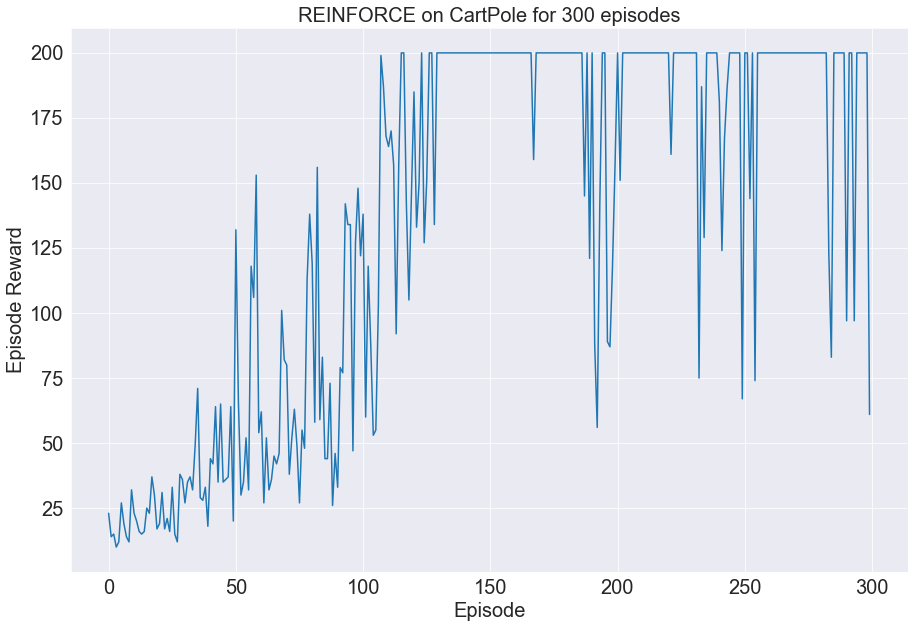

In [25]:
sns.set_style("darkgrid")
plt.figure(figsize=(15,10))
plt.plot(episode_rewards)
plt.title('REINFORCE on CartPole for {} episodes'.format(n_episodes), fontsize=20)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Episode Reward', fontsize=20)
plt.tick_params(labelsize=20)
plt.show()

### Visualize an episode of a trained agent
Once the agent is trained we can visualize how well it does.
The environment object has a function *render()* allowing us to see the interaction between the agent and the environment.

In [27]:
agent.generate_episode(env,  max_steps=200, render=True);